# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [ ]:
%%capture --no-display
!pip install lifetimes
!pip install -U yellowbrick

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from utilities import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from joblib import dump, load

from yellowbrick.cluster.elbow import kelbow_visualizer

from lifetimes.utils import summary_data_from_transaction_data

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Exploratory data analysis
### profile.json
Rewards program users (17000 users x 5 fields)

* gender: (categorical) M, F, O, or null
* age: (numeric) missing value encoded as 118
* id: (string/hash)
* became_member_on: (date) format YYYYMMDD
* income: (numeric)

### portfolio.json
Offers sent during 30-day test period (10 offers x 6 fields)

* reward: (numeric) money awarded for the amount spent
* channels: (list) web, email, mobile, social
* difficulty: (numeric) money required to be spent to receive reward
* duration: (numeric) time for offer to be open, in days
* offer_type: (string) bogo, discount, informational
* id: (string/hash)

### transcript.json
Event log (306648 events x 4 fields)

* person: (string/hash)
* event: (string) offer received, offer viewed, transaction, offer completed
* value: (dictionary) different values depending on event type
  * offer id: (string/hash) not associated with any "transaction"
  * amount: (numeric) money spent in "transaction"
  * reward: (numeric) money gained from "offer completed"
* time: (numeric) hours after start of test

In [3]:
print('The shape of profile is', profile.shape)

The shape of profile is (17000, 5)


In [4]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [5]:
for cc in profile:
    print('Percentage of missing in {} is {}'.format(cc, profile[cc].isna().sum()/17000))

Percentage of missing in gender is 0.12794117647058822
Percentage of missing in age is 0.0
Percentage of missing in id is 0.0
Percentage of missing in became_member_on is 0.0
Percentage of missing in income is 0.12794117647058822


In [6]:
# Remove customers with N/A income data
profile = profile[profile['income'].notnull()]

# Remove customers with unspecified gender
profile = profile[profile['gender'] != 'O']
profile = profile.reset_index(drop=True)

# Change the name of the 'id' column to 'customerid'
profile.columns = update_column_name(profile,
                                     'id',
                                     'customerid')

# Initialize a list that describes the desired DataFrame column
# ordering
column_ordering = ['customerid',
                   'gender',
                   'income']

# Transform the 'became_member_on' column to a datetime object
profile['became_member_on'] =\
    profile['became_member_on'].apply(conv_to_datetime)

# One hot encode a customer's membership start year
profile['membershipstartyear'] =\
    profile['became_member_on'].apply(lambda elem: elem.year)

membershipstartyear_df = pd.get_dummies(profile['membershipstartyear'])
column_ordering.extend(membershipstartyear_df.columns.values)

# One hot encode a customer's age range
min_age_limit = np.int(np.floor(np.min(profile['age'])/10)*10)
max_age_limit = np.int(np.ceil(np.max(profile['age'])/10)*10)

profile['agerange'] =\
    pd.cut(profile['age'],
           (range(min_age_limit,max_age_limit + 10, 10)),
           right=False)

profile['agerange'] = profile['agerange'].astype('str')

agerange_df = pd.get_dummies(profile['agerange'])
column_ordering.extend(agerange_df.columns.values)

# Transform a customer's gender from a character to a number
binarizerobj = LabelBinarizer()
profile['gender'] = binarizerobj.fit_transform(profile['gender'])

gender_integer_map = {}
for elem in binarizerobj.classes_:
    gender_integer_map[elem] = binarizerobj.transform([elem])[0,0]

# Appened one hot encoded age range and membership start year variables
profile = pd.concat([profile,
                     agerange_df,
                     membershipstartyear_df], axis=1)

# Drop depcreated columns
profile = profile.drop(columns=['age',
                                'agerange',
                                'became_member_on',
                                'membershipstartyear'])
profile = profile[column_ordering]

In [7]:
profile.head()

,customerid,gender,income,2013,2014,2015,2016,2017,2018,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,0610b486422d4921ae7d2bf64640c50b,0,112000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,0,100000.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,1,70000.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,389bc3fa690240e798340f5a15918d5c,1,53000.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,2eeac8d8feae4a8cad5a6af0499a211d,1,51000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [8]:
gender_integer_map

{'F': 0, 'M': 1}

In [9]:
# Change the name of the 'id' column to 'offerid'
columns = update_column_name(portfolio,
                             'id',
                             'offerid')

# Change the name of the 'duration' column to 'durationdays'
portfolio.columns = update_column_name(portfolio,
                                       'duration',
                                       'durationdays')

# Remove underscores from column names
portfolio.columns = [re.sub('_', '', elem) for elem in columns]

# Initialize a list that stores the desired output DataFrame 
# column ordering
column_ordering = ['offerid',
                   'difficulty',
                   'durationdays',
                   'reward']

# One hot encode the 'offertype' column
offertype_df = pd.get_dummies(portfolio['offertype'])

column_ordering.extend(offertype_df.columns.values)

# One hot encode the 'channels' columns
ml_binarizerobj = MultiLabelBinarizer()
ml_binarizerobj.fit(portfolio['channels'])

channels_df =\
    pd.DataFrame(ml_binarizerobj.transform(portfolio['channels']),
    columns=ml_binarizerobj.classes_)

column_ordering.extend(channels_df.columns.values)

# Replace the 'offertype' and 'channels' columns
portfolio = pd.concat([portfolio, offertype_df, channels_df], axis=1)

portfolio = portfolio.drop(columns=['offertype', 'channels'])
portfolio = portfolio[column_ordering]

In [10]:
portfolio

,offerid,difficulty,durationdays,reward,bogo,discount,informational,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,0,0,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,4,0,0,0,1,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,0,0,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,0,1,0,1,0,0,1
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,0,1,0,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,0,1,0,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,0,0,1,1,1,1,0
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,0,0,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,0,1,0,1,1,0,1


In [11]:
# Change the name of the 'person' column to 'customerid'
transcript.columns = update_column_name(transcript,
                                        'person',
                                        'customerid')

# Remove customer id's that are not in the customer profile DataFrame
select_data = transcript['customerid'].isin(profile['customerid'])
transcript = transcript[select_data]

percent_removed = 100 * (1 - select_data.sum() / select_data.shape[0])
print("Percentage of transactions removed: %.2f %%" % percent_removed)

# Convert from hours to days
transcript['time'] /= 24.0

# Change the name of the 'time' column to 'timedays'
transcript.columns = update_column_name(transcript,
                                        'time',
                                        'timedays')

# Select customer offers
pattern_obj = re.compile('^offer (?:received|viewed|completed)')

h_is_offer = lambda elem: pattern_obj.match(elem) != None

is_offer = transcript['event'].apply(h_is_offer)

offer_data = transcript[is_offer].copy()
offer_data = offer_data.reset_index(drop=True)

# Initialize a list that describes the desired output DataFrame
# column ordering
column_order = ['offerid', 'customerid', 'timedays']

# Create an offerid column
offer_data['offerid'] =\
    offer_data['value'].apply(lambda elem: list(elem.values())[0])

# Transform a column that describes a customer offer event
pattern_obj = re.compile('^offer ([a-z]+$)')

h_transform = lambda elem: pattern_obj.match(elem).groups(1)[0]

offer_data['event'] = offer_data['event'].apply(h_transform)

# One hot encode customer offer events
event_df = pd.get_dummies(offer_data['event'])
column_order.extend(event_df.columns.values)

# Create a DataFrame that describes customer offer events
offer_data = pd.concat([offer_data, event_df], axis=1)
offer_data.drop(columns=['event', 'value'])
offer_data = offer_data[column_order]

# Select customer transaction events
transaction = transcript[is_offer == False]
transaction = transaction.reset_index(drop=True)

# Transform customer transaction event values
transaction['amount'] =\
    transaction['value'].apply(lambda elem: list(elem.values())[0])

# Create a DataFrame that describes customer transactions
transaction = transaction.drop(columns=['event', 'value'])
column_order = ['customerid', 'timedays', 'amount']
transaction = transaction[column_order]

Percentage of transactions removed: 12.31 %


In [12]:
transaction.head()

,customerid,timedays,amount
0,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
2,54890f68699049c2a04d415abc25e717,0.0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


In [13]:
offer_data.head()

,offerid,customerid,timedays,completed,received,viewed
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,0,1,0
1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,0,1,0
2,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0.0,0,1,0
3,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d,0.0,0,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0.0,0,1,0


In [14]:
clean_data_csvfile = "./data/clean_data.csv"

if os.path.exists(clean_data_csvfile):
    clean_data = pd.read_csv(clean_data_csvfile)
else:
    clean_data = create_offeranalysis_dataset(profile,
                                              portfolio,
                                              offer_data,
                                              transaction)

    clean_data.to_csv(clean_data_csvfile, index=False)
    
clean_data = clean_data.drop(columns=['time',
                                      'customerid',
                                      'email',
                                      'informational'])

column_ordering = ['offerid', 'totalamount']
column_ordering.extend([elem for elem in clean_data.columns if elem not in column_ordering])

clean_data = clean_data[column_ordering]
clean_data.head()

,offerid,totalamount,offersuccessful,difficulty,durationdays,reward,bogo,discount,mobile,social,...,"[10, 20)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)","[100, 110)"
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,1,5,7,5,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,48.31,1,10,5,10,1,0,1,1,...,0,0,0,0,1,0,0,0,0,0
2,5a8bc65990b245e5a138643cd4eb9837,23.43,0,0,3,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,52.24,0,5,7,5,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,fafdcd668e3743c1bb461111dcafc2a4,5.12,0,10,10,2,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0


## Train test split the data

In [15]:
random_state = 1234567890

class_label_name = 'offersuccessful'

variables = clean_data.drop(columns=[class_label_name])
class_label = clean_data.filter([class_label_name])

(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(variables.values,
                            class_label.values,
                            test_size=0.2,
                            random_state=random_state)

variable_names = variables.columns[2:]

offerid_train = X_train[:, 0]
totalamount_train = X_train[:, 1]
X_train = X_train[:, 2:].astype('float64')

offerid_test = X_test[:, 0]
totalamount_test = X_test[:, 1]
X_test = X_test[:, 2:].astype('float64')

y_train = y_train.ravel()
y_test = y_test.ravel()

In [16]:
print(variable_names)

Index(['difficulty', 'durationdays', 'reward', 'bogo', 'discount', 'mobile',
       'social', 'web', 'gender', 'income', '2013', '2014', '2015', '2016',
       '2017', '2018', '[10, 20)', '[20, 30)', '[30, 40)', '[40, 50)',
       '[50, 60)', '[60, 70)', '[70, 80)', '[80, 90)', '[90, 100)',
       '[100, 110)'],
      dtype='object')


In [17]:
# Only interested in customer data
training_variables = pd.DataFrame(X_train, columns=variable_names)
training_labels = pd.DataFrame(y_train, columns=[class_label_name])
training_offerid = pd.DataFrame(offerid_train, columns=['offerid'])

training_data = pd.concat([training_offerid,
                           training_variables,
                           training_labels], axis=1)

training_data = training_data.drop(columns=['difficulty',
                                            'durationdays',
                                            'reward',
                                            'bogo',
                                            'discount',
                                            'mobile',
                                            'social',
                                            'web'])

training_data.head()

,offerid,gender,income,2013,2014,2015,2016,2017,2018,"[10, 20)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)","[100, 110)",offersuccessful
0,fafdcd668e3743c1bb461111dcafc2a4,0.0,72000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,119000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,104000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,3f207df678b143eea3cee63160fa8bed,1.0,71000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,38000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [18]:
percent_success = initialize_percent_success(portfolio, training_data)

In [19]:
percent_success

,offerid,count,percentsuccess,difficulty,durationdays,reward,bogo,discount,informational,email,mobile,social,web
0,fafdcd668e3743c1bb461111dcafc2a4,5225,75.138756,10,10,2,0,1,0,1,1,1,1
1,2298d6c36e964ae4a3e7e9706d1fb8c2,5198,73.335898,7,7,3,0,1,0,1,1,1,1
2,f19421c1d4aa40978ebb69ca19b0e20d,5196,61.528099,5,5,5,1,0,0,1,1,1,1
3,ae264e3637204a6fb9bb56bc8210ddfd,5302,54.696341,10,7,10,1,0,0,1,1,1,0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,5248,51.753049,10,5,10,1,0,0,1,1,1,1
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,5307,48.030903,5,7,5,1,0,0,1,1,0,1
6,2906b810c7d4411798c6938adc9daaa5,5293,47.836766,10,7,2,0,1,0,1,1,0,1
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,5265,45.204179,20,10,5,0,1,0,1,0,0,1
8,3f207df678b143eea3cee63160fa8bed,5177,7.938961,0,4,0,0,0,1,1,1,0,1
9,5a8bc65990b245e5a138643cd4eb9837,5257,6.011033,0,3,0,0,0,1,1,1,1,0


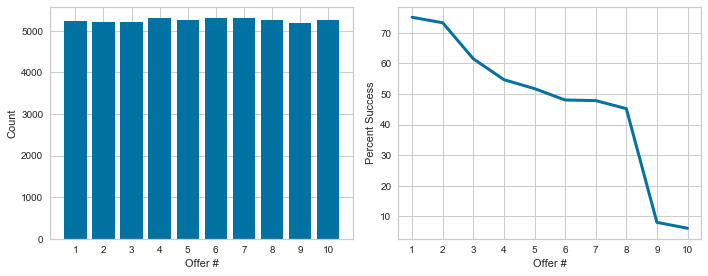

In [20]:
f, ax = plt.subplots(figsize=(10, 4),
                     nrows=1,
                     ncols=2)

ax[0].bar(percent_success.index + 1, percent_success['count'])
ax[0].set_xticks(np.arange(0,10) + 1)
ax[0].set_xlabel('Offer #')
ax[0].set_ylabel('Count')

ax[1].plot(percent_success.index + 1,
           percent_success['percentsuccess'],
           linewidth=3)
ax[1].set_xticks(np.arange(0,10) + 1)
ax[1].set_xlabel('Offer #')
ax[1].set_ylabel('Percent Success')
plt.tight_layout()

In [21]:
# Variable transformation

variables_to_scale = ['difficulty', 'durationdays', 'reward', 'income']

min_max_scaler = {}

for idx in range(len(variables_to_scale)):
    column_idx = np.argwhere(variable_names == variables_to_scale[idx])[0, 0]
    
    cur_column = variables_to_scale[idx]
    
    min_max_scaler[cur_column] = MinMaxScaler()
    min_max_scaler[cur_column].fit(X_train[:, column_idx].reshape(-1, 1))

    transformed_values =\
        min_max_scaler[cur_column].transform(X_train[:, column_idx].reshape(-1, 1))

    X_train[:, column_idx] = transformed_values.reshape(1, -1)
    
    transformed_values =\
        min_max_scaler[cur_column].transform(X_test[:, column_idx].reshape(-1, 1))

    X_test[:, column_idx] = transformed_values.reshape(1, -1)

In [22]:
gender_integer_map

{'F': 0, 'M': 1}

offerid: fafdcd668e3743c1bb461111dcafc2a4
Offer successful
	Average customer income: $66030.4
	Average customer age: 55.6 [years]
Offer unsuccessful
	Average customer income: $56994.5
	Average customer age: 52.7 [years]
   gender  percentage successful
0    Male   55.348956        Yes
1  Female   44.651044        Yes
2    Male   69.899923         No
3  Female   30.100077         No
    membershipstartyear  percentage successful
0                  2013    2.266938        Yes
6                  2013    0.384911         No
1                  2014    5.501783        Yes
7                  2014    2.001540         No
2                  2015   13.983698        Yes
8                  2015    2.155504         No
3                  2016   25.496689        Yes
9                  2016    2.925327         No
4                  2017   35.506877        Yes
10                 2017   39.568899         No
5                  2018   17.244014        Yes
11                 2018   52.963818         No
offe

offerid: 5a8bc65990b245e5a138643cd4eb9837
Offer successful
	Average customer income: $63499.6
	Average customer age: 56.8 [years]
Offer unsuccessful
	Average customer income: $64001.6
	Average customer age: 55.3 [years]
   gender  percentage successful
0    Male   55.696203        Yes
1  Female   44.303797        Yes
2    Male   57.336572         No
3  Female   42.663428         No
    membershipstartyear  percentage successful
0                  2013    2.531646        Yes
6                  2013    1.619105         No
1                  2014    6.012658        Yes
7                  2014    4.169197         No
2                  2015   12.974684        Yes
8                  2015   10.422991         No
3                  2016   27.531646        Yes
9                  2016   20.461445         No
4                  2017   35.759494        Yes
10                 2017   38.575187         No
5                  2018   15.189873        Yes
11                 2018   24.752074         No


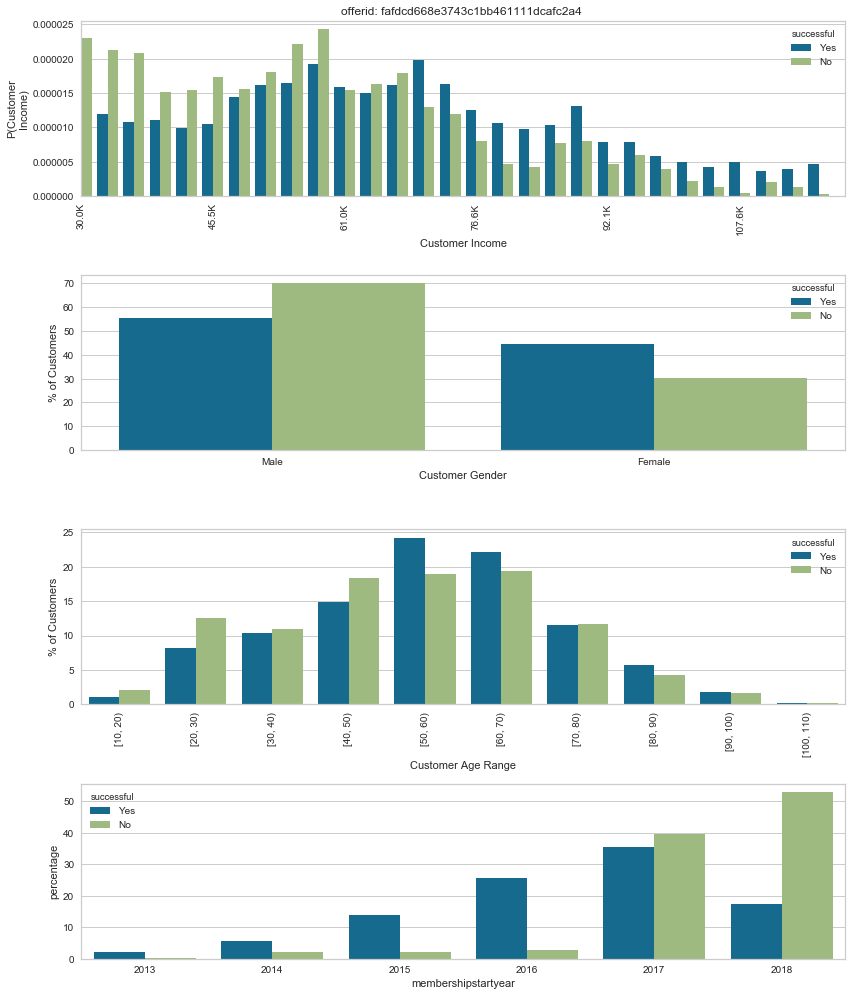

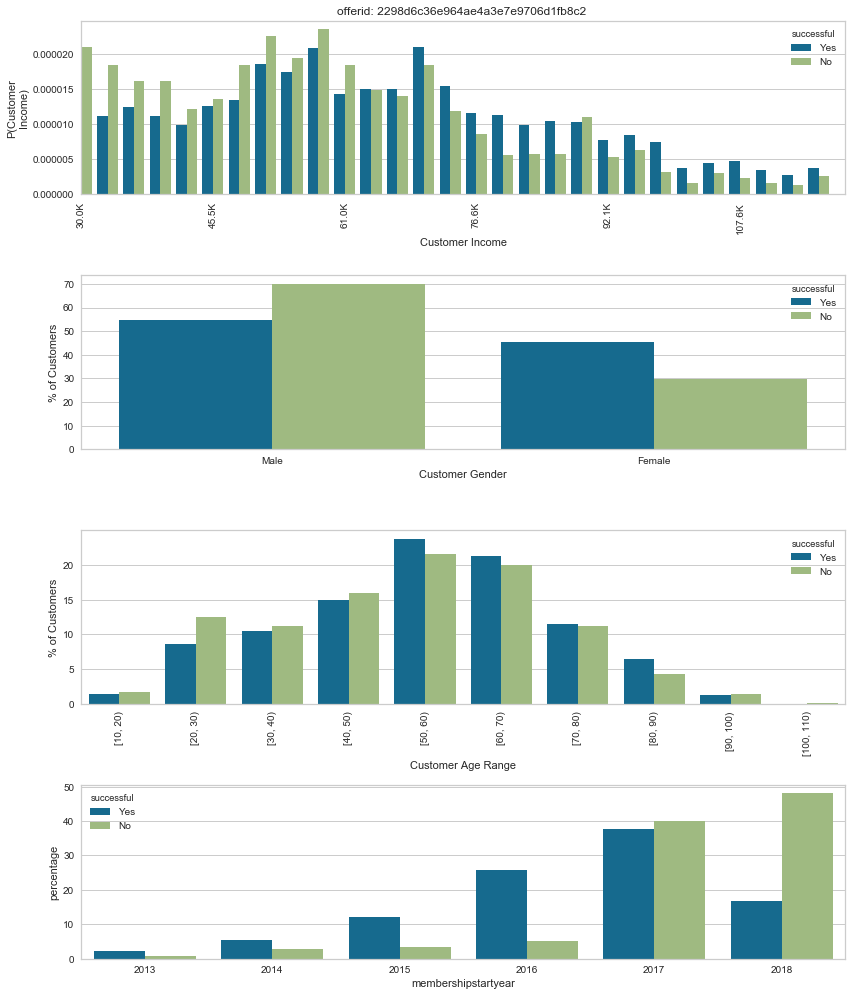

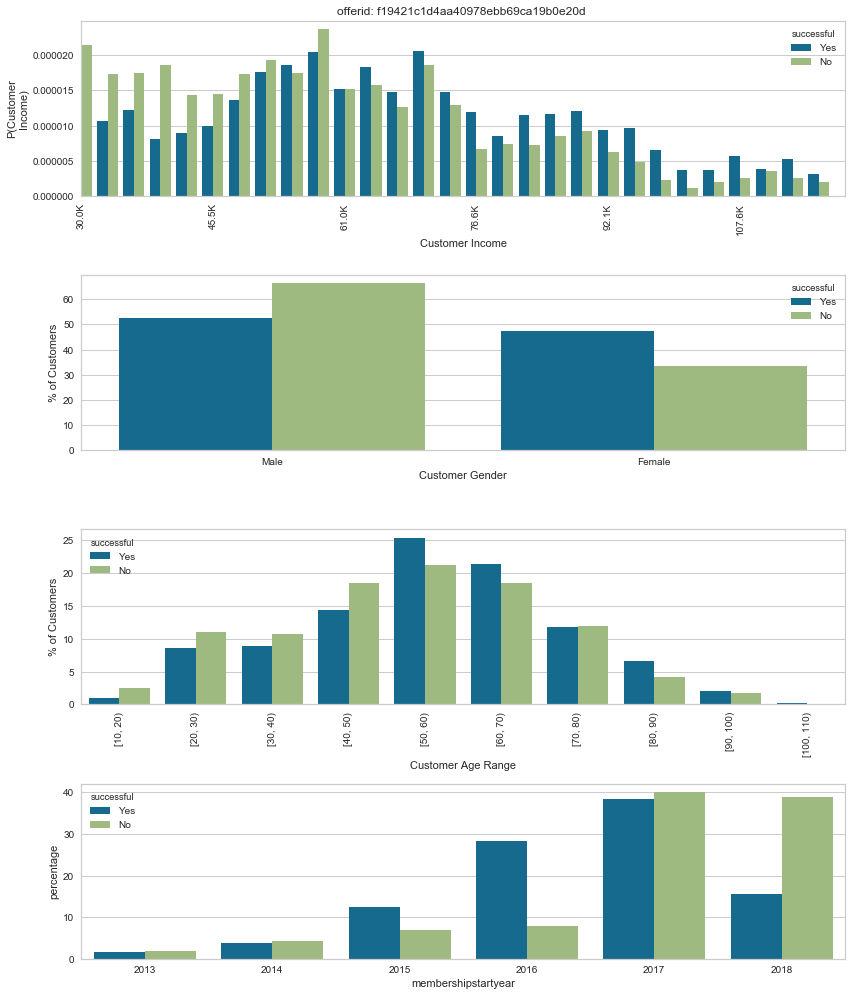

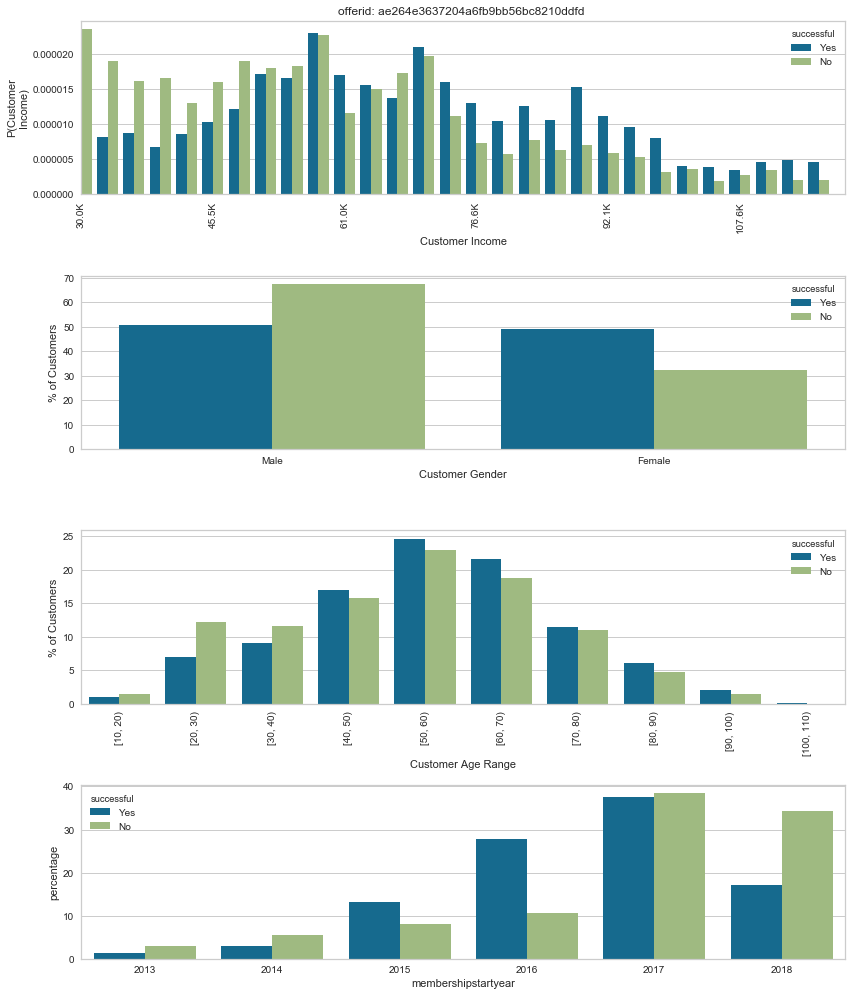

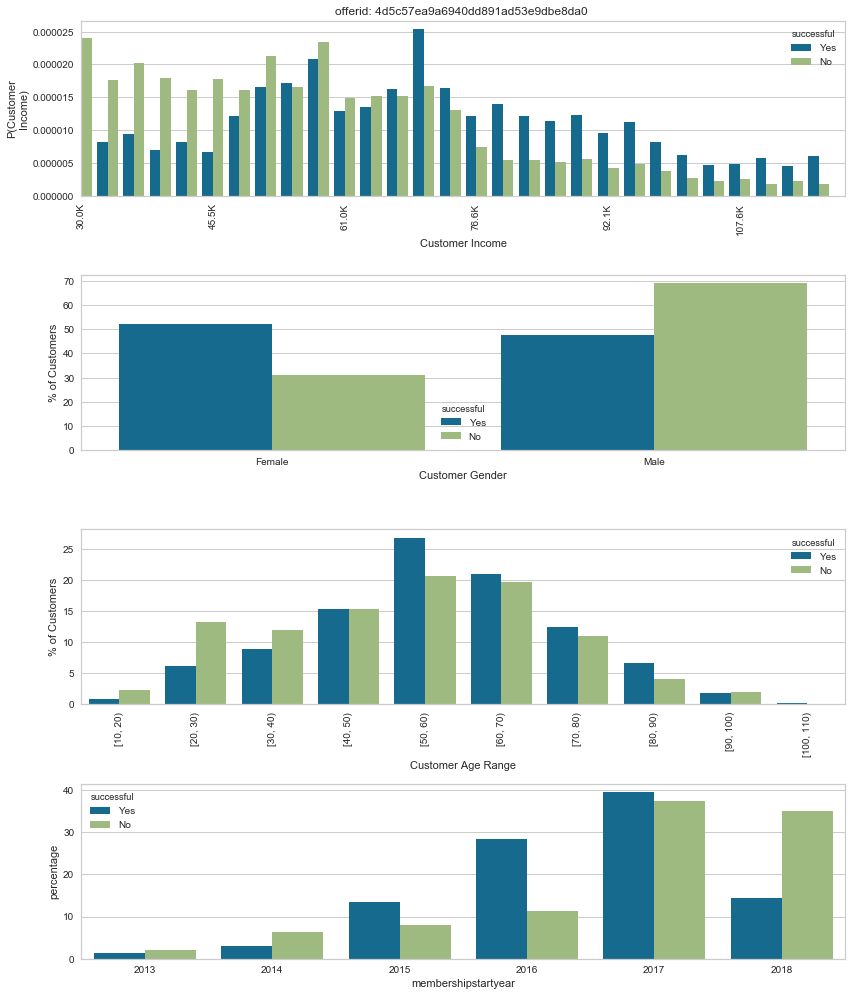

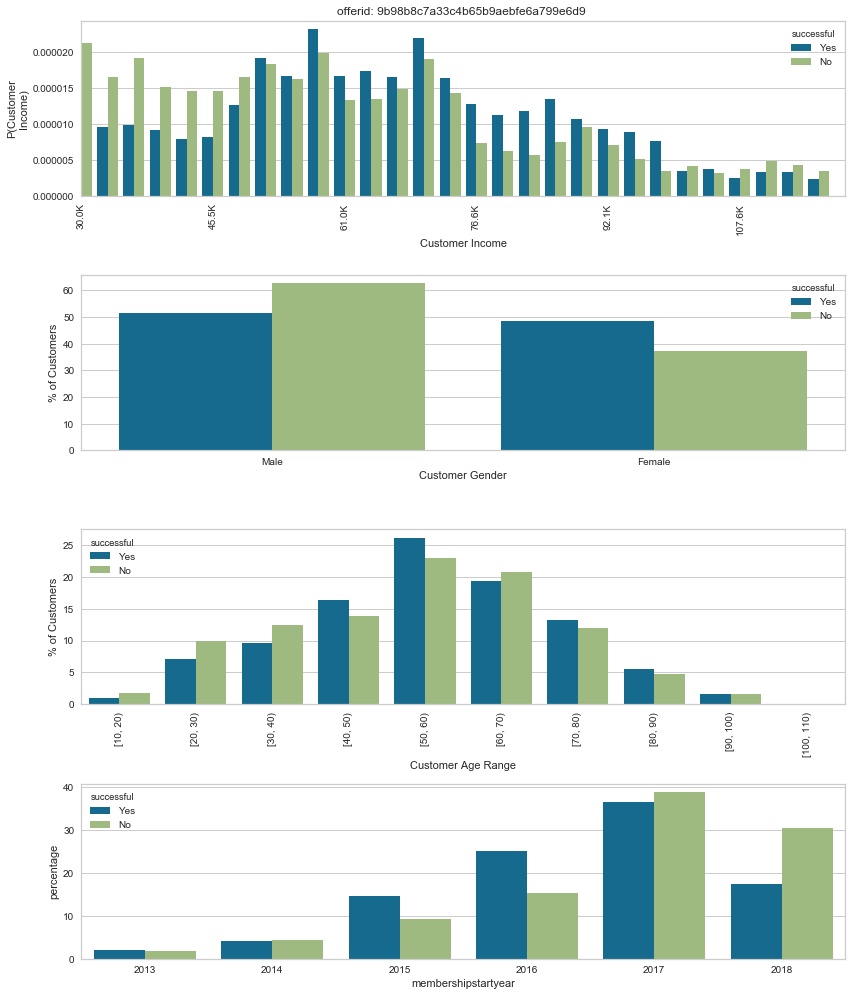

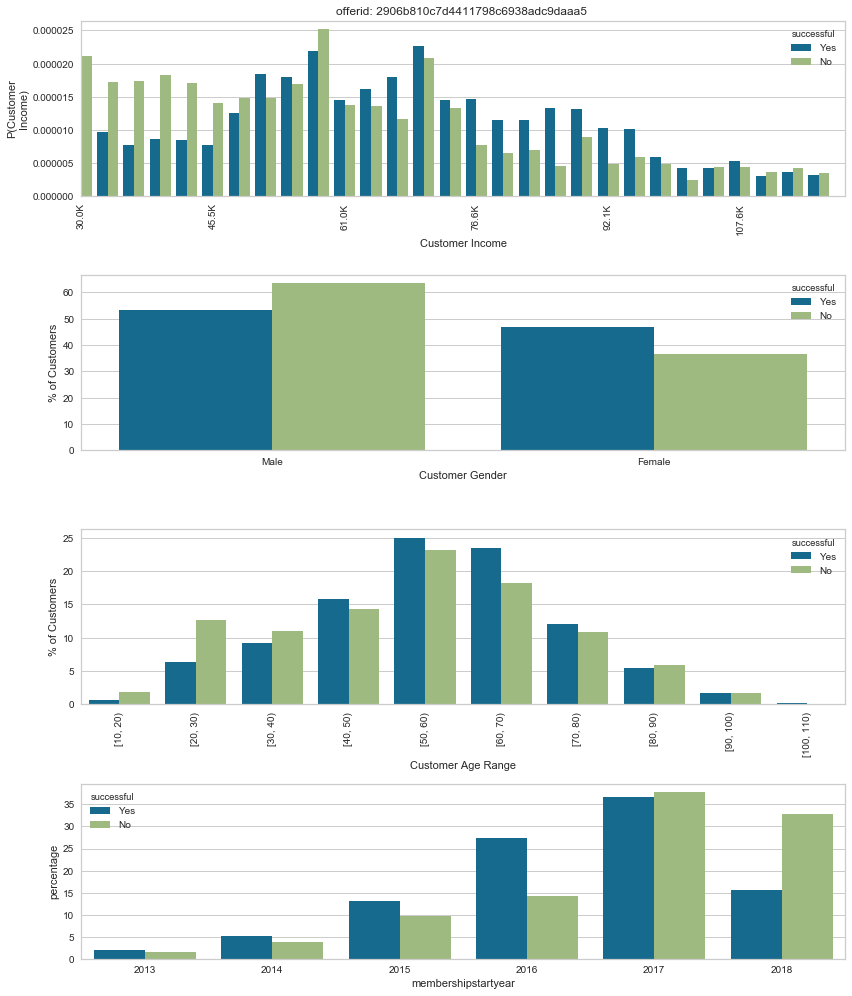

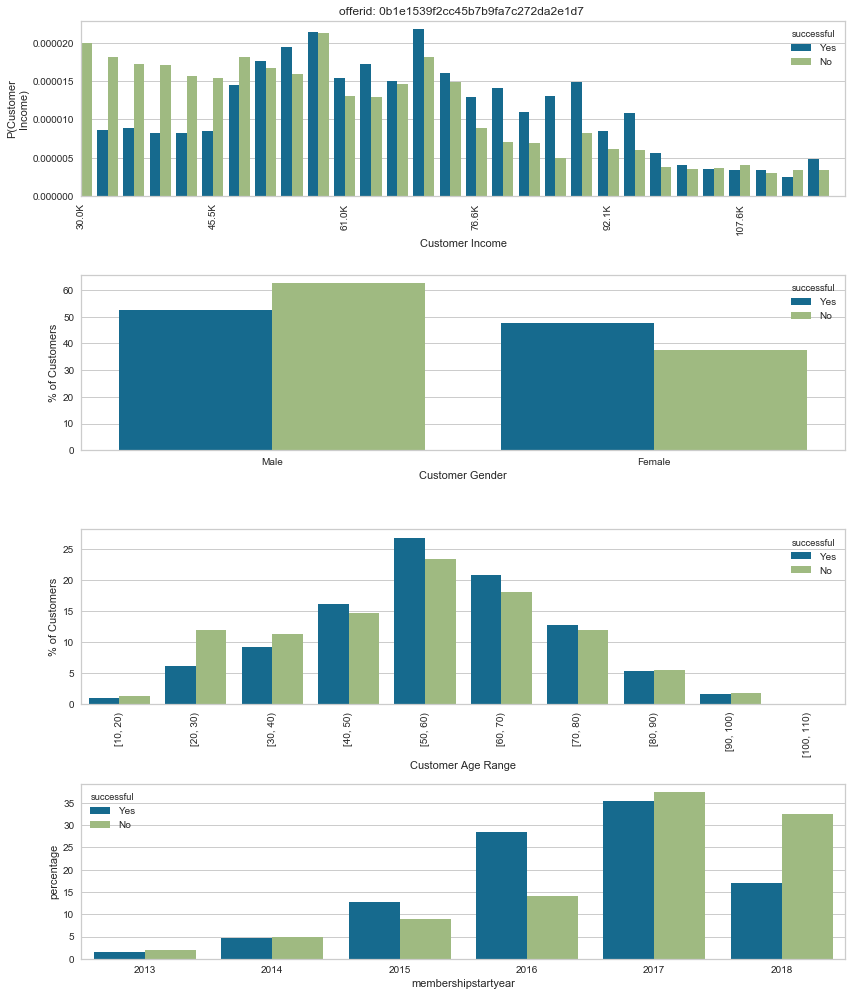

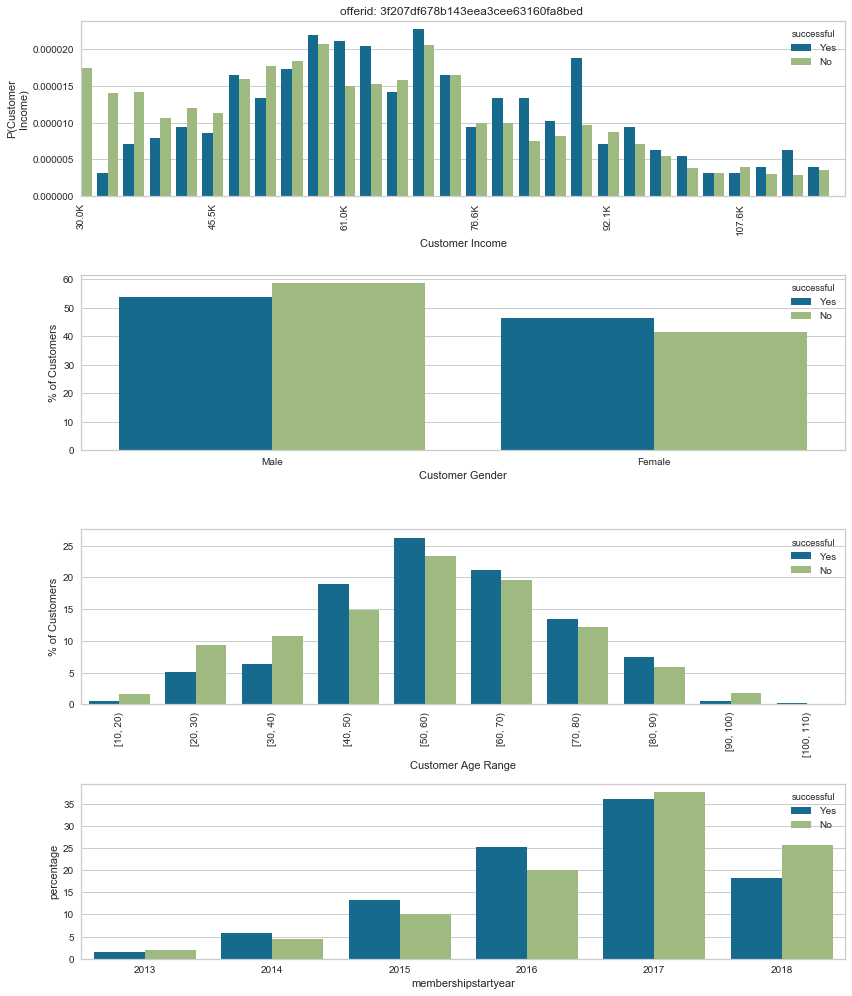

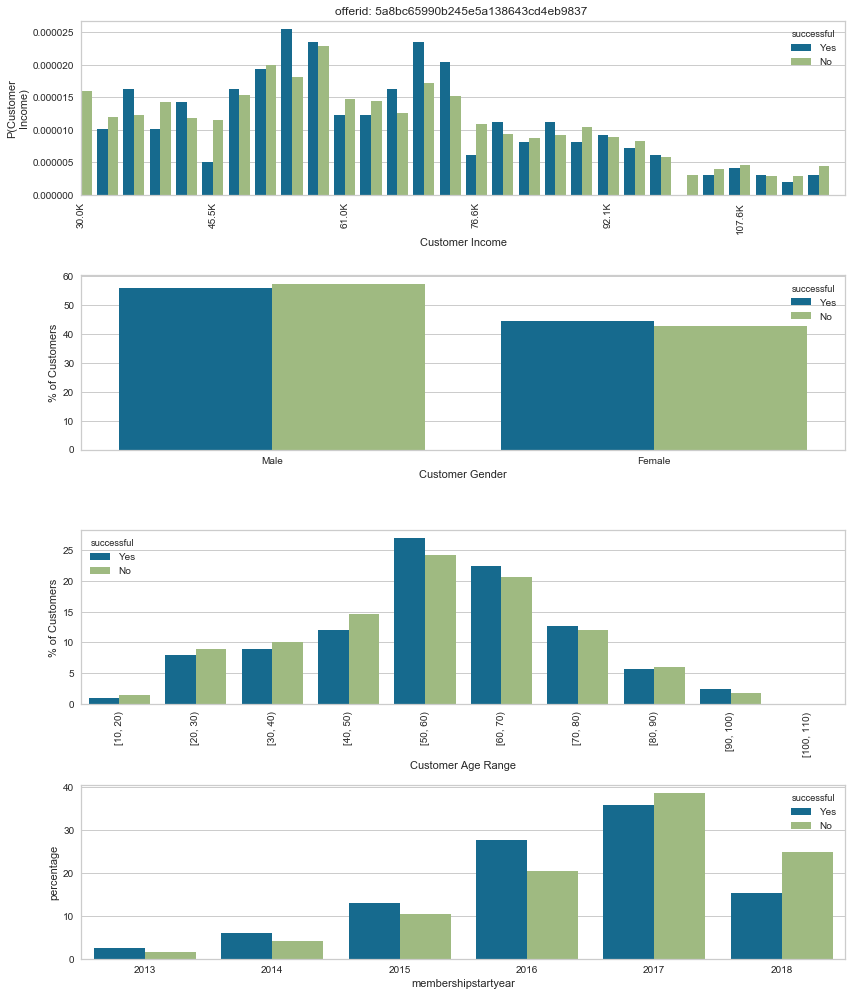

In [24]:
for offer_number in range(10):
    explore_customer_offer(offer_number, percent_success, training_data, gender_integer_map)

In [25]:
naive_predictor_accuracy = accuracy_score(y_train,np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))

print("Naive predictor accuracy: %.3f" % (naive_predictor_accuracy))
print("Naive predictor f1-score: %.3f" % (naive_predictor_f1score))

Naive predictor accuracy: 0.472
Naive predictor f1-score: 0.641


In [26]:
model_dir = "./models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
lr_model_path = os.path.join(model_dir, 'lr_clf.joblib')

scorer = make_scorer(fbeta_score,
                     beta=0.5)

if os.path.exists(lr_model_path):
    lr_random = load(lr_model_path)
else:
    lr_clf = LogisticRegression(random_state=random_state,
                                solver='liblinear')

    random_grid = {'penalty': ['l1', 'l2'],
                   'C': [1.0, 0.1, 0.01]}

    lr_random = RandomizedSearchCV(estimator = lr_clf,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 6,
                                   cv = 3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs = 3)

    lr_random.fit(X_train, y_train)

    dump(lr_random, lr_model_path)

In [27]:
def evaluate_model_performance(clf,
                               X_train,
                               y_train):
    """ Prints a model's accuracy and F1-score
    
    INPUT:
        clf: Model object
        
        X_train: Training data matrix/

        y_train: Expected model output vector
    
    OUTPUT:
        clf_accuracy: Model accuracy
        
        clf_f1_score: Model F1-score"""
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

In [28]:
evaluate_model_performance(lr_random.best_estimator_,
                           X_train,
                           y_train)

LogisticRegression model accuracy: 0.723
LogisticRegression model f1-score: 0.718


(0.7229740032019517, 0.7175091831380093)

In [29]:
rf_model_path = os.path.join(model_dir, 'rf_clf.joblib')

if os.path.exists(rf_model_path):
    rf_random = load(rf_model_path)
else:
    rf_clf = RandomForestClassifier(random_state=random_state)

    # Number of trees in random forest
    n_estimators = [10, 30, 50, 100, 150, 200, 250, 300]

    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']

    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.arange(3, 11)]
    max_depth.append(None)

    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]

    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

    rf_random = RandomizedSearchCV(estimator = rf_clf,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 100,
                                   cv = 3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs = 3)

    rf_random.fit(X_train, y_train)
    
    dump(rf_random, rf_model_path)

In [30]:
evaluate_model_performance(rf_random.best_estimator_,
                           X_train,
                           y_train)

RandomForestClassifier model accuracy: 0.744
RandomForestClassifier model f1-score: 0.738


(0.7444156438209957, 0.7381063979376611)

Text(0.5, 1.0, 'Random Forest Estimated Feature Importance')

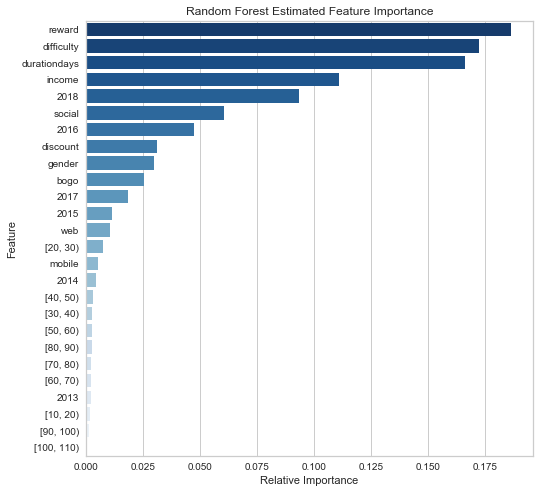

In [31]:
relative_importance = rf_random.best_estimator_.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

feature_importance =\
    pd.DataFrame(list(zip(variable_names,
                          relative_importance)),
                 columns=['feature', 'relativeimportance'])

feature_importance = feature_importance.sort_values('relativeimportance',
                                                    ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

palette = sns.color_palette("Blues_r", feature_importance.shape[0])

plt.figure(figsize=(8, 8))
sns.barplot(x='relativeimportance',
            y='feature',
            data=feature_importance,
            palette=palette)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Random Forest Estimated Feature Importance')

In [32]:
evaluate_model_performance(rf_random.best_estimator_,
                           X_test,
                           y_test)

RandomForestClassifier model accuracy: 0.729
RandomForestClassifier model f1-score: 0.721


(0.7288251886864374, 0.721303768706417)